<a href="https://colab.research.google.com/github/AndyLam1224/Fake-News-Detector/blob/master/Fake_News_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt  
import string
import re
import csv
import nltk 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS 

vocab_size = 30000
embed_dim = 128
max_length = 28
lstm_out = 196
batch_size = 64

In [0]:
# Fake Tweets
onion = pd.read_csv("/content/TheOnion_tweets.csv")  
fakecnn = pd.read_csv("/content/TheFakeCNN_tweets.csv")
fake = pd.read_csv("/content/fake.csv", usecols=['title'])

fake = fake.rename(columns={'title':'text'})
fake = pd.concat([fake, onion, fakecnn])
fake['is_fake'] = 1

# Real Tweets
npr = pd.read_csv("/content/npr_tweets.csv")
nytimes = pd.read_csv("/content/nytimes_tweets.csv")
econ = pd.read_csv("/content/EconUS_tweets.csv")
breakingnews = pd.read_csv("/content/breakingnews_tweets.csv")
wsj = pd.read_csv("/content/wsj_tweets.csv")
washpost = pd.read_csv("/content/washingtonpost_tweets.csv")
bbc = pd.read_csv("/content/BBCBreaking_tweets.csv")

real = pd.concat([npr,nytimes, econ, breakingnews, wsj, washpost, bbc], axis=0)
real['is_fake'] = 0


In [0]:

def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    # Strip random leading 'b' from curated tweets
    if text[0] == 'b':
      text = text[1:]

    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() 
    text = text.replace('xexx','')
    text = nltk.word_tokenize(text)
    return text


real = real[~real['text'].astype(str).str.startswith('RT')]
real['text'] = real['text'].astype(str).apply(lambda x:initial_clean(x))

fake = fake[~fake['text'].astype(str).str.startswith('RT')]
fake['text'] = fake['text'].astype(str).apply(lambda x:initial_clean(x))

# new_test = new_test[~new_test['text'].astype(str).str.startswith('RT')]
# new_test['text'] = new_test['text'].astype(str).apply(lambda x:initial_clean(x))
# new_test = shuffle(new_test)

In [115]:
# Remove all stopwords from text
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(text):

  text = [word for word in text if word not in stop_words]
  text = ' '.join(text)
  return text

fake['text'] = fake['text'].apply(remove_stopwords)
real['text'] = real['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [116]:
real.head(20)

,id,created_at,text,is_fake
0,1248754650205032448,2020-04-10 23:28:04,meet rumi wandered onto army base syria early ...,0
1,1248751603257159683,2020-04-10 23:15:57,agricultural laborers officially declared esse...,0
2,1248747874239893507,2020-04-10 23:01:08,federal appeals court effectively reinstated b...,0
3,1248743573157281792,2020-04-10 22:44:03,coronavirus hitting black americans especially...,0
4,1248743075872210946,2020-04-10 22:42:04,many universities hesitant make changes gradin...,0
5,1248739811676098561,2020-04-10 22:29:06,bernie sanders race joe bidens campaign reachi...,0
6,1248735791095992320,2020-04-10 22:13:07,new delhi typically polluted air world amid in...,0
7,1248733536854724608,2020-04-10 22:04:10,italy governmentissued quarantine since march ...,0
8,1248728741645365250,2020-04-10 21:45:06,looking ways pass time weekendnnhere art proje...,0
9,1248727141799399424,2020-04-10 21:38:45,bassist andy gonzxcxalez bridged worlds latin ...,0


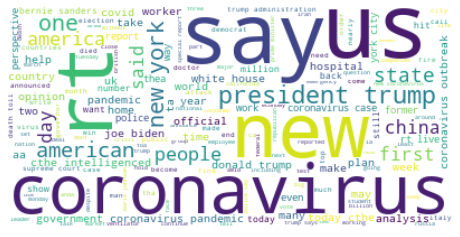

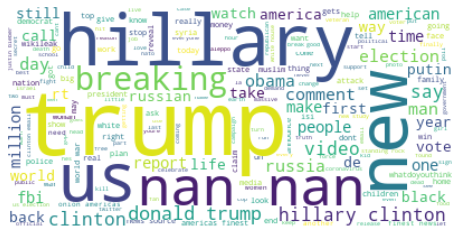

In [117]:
# Generate word clouds to visualize most common words
def generate_cloud(df):
    stopwords = set(STOPWORDS)
    words = " ".join(text for text in df.text)
    wordcloud = WordCloud(background_color = 'white', stopwords=stopwords, max_font_size=80, max_words=300).generate(words)
   
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_cloud(real)
generate_cloud(fake)

In [118]:
# Concatenate real and fake datasets into one
data = pd.concat([real,fake], axis=0)
data = data.drop(columns=['id', 'created_at'])
data = data.dropna()
data = shuffle(data)
data.head()


,text,is_fake
9911,obama knew clintons server lied american people,1
890,irans military admits cunintentionallyd shot u...,0
2815,young boomers gen xers millennials faced diffe...,0
2138,rt stunning exhaustivelysourced gorgeously ill...,0
7580,nhl canadiens edge past islanders,1


In [0]:
# Reduce words to stemmed versions
stemmer = PorterStemmer()
def stem_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)    
data.text = data.text.apply(stem_text)    

In [120]:
data.head()

,text,is_fake
9911,obama knew clinton server lie american peopl,1
890,iran militari admit cunintentionallyd shot ukr...,0
2815,young boomer gen xer millenni face differ econ...,0
2138,rt stun exhaustivelysourc gorgeous illustr pic...,0
7580,nhl canadien edg past island,1


In [0]:
X = data['text']
y = data['is_fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
  # Tokenize words pad sequences to max length of 28 words
  tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")
  tokenizer.fit_on_texts(X_train)
  word_index = tokenizer.word_index

  training_sequences = tokenizer.texts_to_sequences(X_train)
  training_padded = pad_sequences(training_sequences,maxlen = 28, padding = 'post', truncating='post')
  X_train = np.array(training_padded)

  testing_sequences = tokenizer.texts_to_sequences(X_test)
  testing_padded = pad_sequences(testing_sequences, maxlen=28, padding = 'post', truncating='post')
  X_test = np.array(testing_padded)

In [132]:
model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = X_train.shape[1],mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, activation = 'relu', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=3, batch_size=batch_size, validation_data = (X_test, y_test))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 28, 128)           3840000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 197       
Total params: 4,094,997
Trainable params: 4,094,997
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33606 samples, validate on 8402 samples
Epoch 1/3
33606/33606 [==============================] - 107s 3ms/step - loss: 0.3260 - accuracy: 0.8560 - val_loss: 0.2091 - val_accuracy: 0.9167
Epoch 2/3
33606/33606 [==============================] - 106s 3ms/step - loss: 0.1363 - accuracy: 0.9483 - val_loss: 0.1991 - val_accuracy: 0.9213
Epoch 3/3
33606/33606 [==============================] - 110s 3ms/step - loss: 0.0743 - accuracy: 0.9728 - val_loss: 0.2316 - val_accuracy: 0.9180


In [133]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score)) 
print("acc: %.2f" % (acc)) 

score: 0.23
acc: 0.92


In [134]:
pred = model.predict(X_test,verbose = 2)
for i in range(len(pred)):
  if pred[i] <= 0.5:
    pred[i] = 0
  else:
    pred[i] = 1
y_test = np.array(y_test).reshape(-1,1)
num_cor = 0

for j in range(len(y_test)):
  if pred[i] == y_test[i]:
    num_cor += 1

print("Total number correct: ", num_cor, "out of: ", y_test.size)

Total number correct:  8402 out of:  8402


In [135]:
print(score, acc)

0.23161851658874455 0.9179956912994385


In [138]:
twt =["german priest charged with 280 counts of sexual abuse. Seeks a new job in the US"]

#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, padding = 'post', truncating='post')
is_fake = model.predict(twt,batch_size=1,verbose = 2)
print(is_fake)
if(is_fake < 0.5):
    print("Real")
else:
    print("Fake")

[[0.88969344]]
Fake
